In [1]:
import pandas as pd
import numpy as np

from sklearn.externals import joblib
from sklearn.cluster import MiniBatchKMeans

import umap
import hdbscan

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import PreprocessText

import os
os.environ["JOBLIB_TEMP_FOLDER"] = "/tmp"

In [ ]:
df = pd.read_pickle('data/EPMC/eye_in_new_keywords.pkl')
df.set_index('pmid',inplace=True)
titles = df.title
del df

In [2]:
print('load abstracts')
abstracts = pd.read_pickle('data/EPMC/eye_in_new_keywords_ABSTRACTS_LEMMA.pkl')
pmids = abstracts.index
abstract_lengths = abstracts.str.split().str.len().values

print('load vectoriser')
countvec = joblib.load('models/sklearn/CountVec.joblib')
features = countvec.get_feature_names()

with open('data/EPMC/eye_in_new_keywords_ABSTRACTS_COUNTVEC.pkl','rb') as f:
    countvec_vectors = pickle.load(f)

term_frequency = countvec_vectors.sum(axis=0).tolist()[0]

#del abstracts
del countvec

print('load lda')
lda = joblib.load('models/sklearn/LDA_50topics_alleyekw.joblib') 
topics = pd.DataFrame(lda.components_,columns=features)

#with open('data/EPMC/eye_in_new_keywords_ABSTRACTS_LDAVEC.pkl','rb') as f:
#    lda_vectors = pickle.load(f)

lda_vectors = lda.transform(countvec_vectors)
max_topics = lda_vectors.argmax(axis=1)
    
del countvec_vectors
del lda

print('load umap')
n_neighbors = 30 
metric = 'euclidean'
min_dist = 0

umap_base = 'models/umap/eyekws_LDA50_umap_neighbors_'
umap_file = umap_base+str(n_neighbors)+'_metric_'+metric+'_dist_'+str(min_dist)+'.pkl'
with open(umap_file,'rb') as f:
    umapper = pickle.load(f)

X_umap = umapper.transform(lda_vectors)

umapper10 = umap.UMAP(n_neighbors=30,min_dist=0,metric='euclidean',n_components=10)
X_umap_10 = umapper10.fit_transform(lda_vectors)

load abstracts
load vectoriser
load lda
load umap


In [5]:
'''
umap_base = 'models/umap/eyekws_LDA50_umap10_neighbors_'
umap_file = umap_base+str(n_neighbors)+'_metric_'+metric+'_dist_'+str(min_dist)+'.pkl'
with open(umap_file,'wb') as f:
    pickle.dump(umapper10,f)
'''

No. clusters: 50
Fraction in largest cluster: 0.037233998832841536
plotting


Text(0.5,1,'50 clusters.')

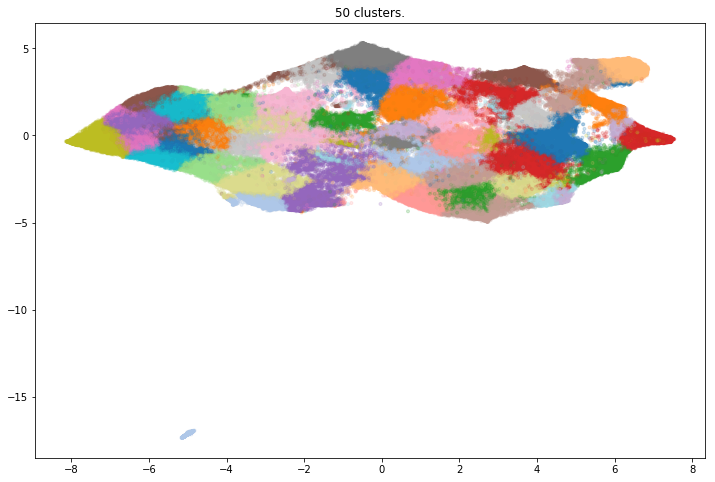

In [3]:
clusterer = MiniBatchKMeans(n_clusters=50)

#clusters = clusterer.fit_predict(lda_vectors[lda_vectors.max(axis=1)>0.2])
clusters = clusterer.fit_predict(X_umap_10[lda_vectors.max(axis=1)>0.2])

unique_idx,cluster_counts = np.unique(clusters, return_counts=True)

n_clusters = len(unique_idx)
frac_in_largest = max(cluster_counts)/len(pmids)
print('No. clusters:', n_clusters)
print('Fraction in largest cluster:',frac_in_largest)

clusters = pd.Series(clusters,index=pmids[lda_vectors.max(axis=1)>0.2])

print('plotting')
plt.figure(figsize=(12,8))
plt.scatter(X_umap[lda_vectors.max(axis=1)>0.2,0], X_umap[lda_vectors.max(axis=1)>0.2,1], 
            c=clusters, cmap='tab20',alpha=0.2,marker='.')

plt.title(str(n_clusters)+ ' clusters.')

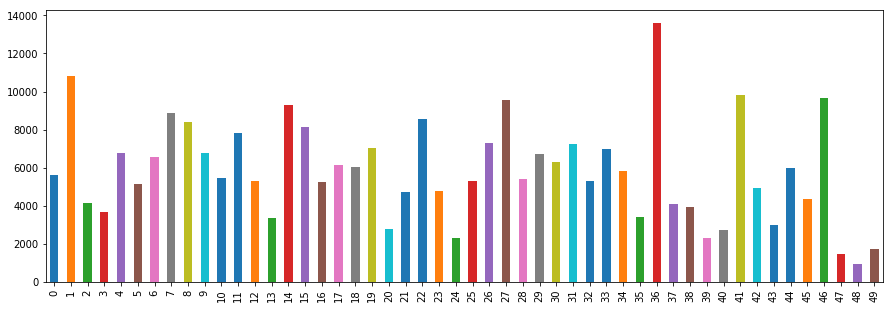

In [4]:
plt.figure(figsize=(15,5))
clusters.value_counts(sort=False).plot.bar()

In [ ]:
with pd.option_context('display.max_colwidth', -1):
    display(titles.loc[titles.index.isin(clusters[clusters==43].index)])

In [13]:
ffs = pd.read_pickle('data/EPMC/ffs_or_predecessors.pkl')
ffs.set_index('pmid',inplace=True)
ffs = ffs[~ffs.index.isnull()]

ffs_abstracts = ffs['abstractText']
ffs_abstracts = PreprocessText.lemmatize_abstracts(ffs_abstracts)
ffs_titles = ffs['title']
ffs_pmids = ffs_abstracts.index
del ffs

countvec = joblib.load('models/sklearn/CountVec.joblib')
count_ffs = countvec.transform(ffs_abstracts)
del countvec

lda = joblib.load('models/sklearn/LDA_50topics_alleyekw.joblib') 
lda_ffs = lda.transform(count_ffs)
lda_ffs = pd.DataFrame(lda_ffs, index=ffs_pmids)
del lda

umap_ffs = umapper.transform(lda_ffs)

Removing missing abstracts
Initial preprocessing: case, punctuation, whitespace
Lemmatizing


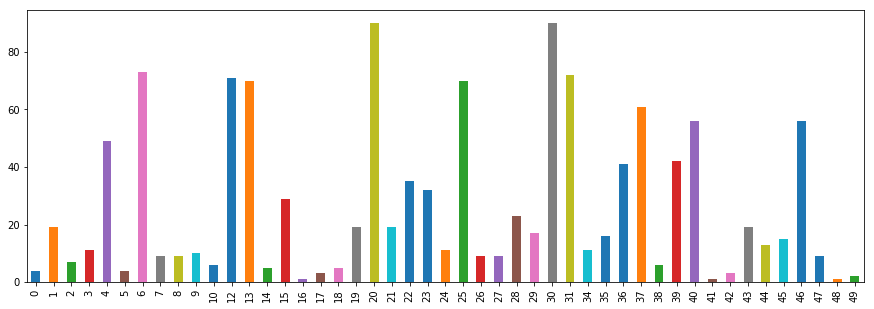

In [15]:
ffs_clusters = clusterer.predict(umap_ffs[lda_ffs.max(axis=1)>0.2])
ffs_clusters = pd.Series(ffs_clusters,index=ffs_pmids[lda_ffs.max(axis=1)>0.2])

plt.figure(figsize=(15,5))
ffs_clusters.value_counts(sort=False).plot.bar()

In [18]:
with pd.option_context('display.max_colwidth', -1):
    display(ffs_titles.loc[ffs_titles.index.isin(ffs_clusters[ffs_clusters==30].index)])

pmid
29164803    Preclinical Evaluation and Optimization of a Cell Therapy Using Human Cord Blood-Derived Endothelial Colony-Forming Cells for Ischemic Retinopathies.                                                                          
29312308    Bruch's Membrane Compartmentalizes Complement Regulation in the Eye with Implications for Therapeutic Design in Age-Related Macular Degeneration.                                                                              
28631889    MicroRNA-containing extracellular vesicles released from endothelial colony-forming cells modulate angiogenesis during ischaemic retinopathy.                                                                                  
29473871    Impaired Cargo Clearance in the Retinal Pigment Epithelium (RPE) Underlies Irreversible Blinding Diseases.                                                                                                                     
29445135    Alteration in nerves and neurotransmitt

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


Text(0,0.5,'difference in inertia')

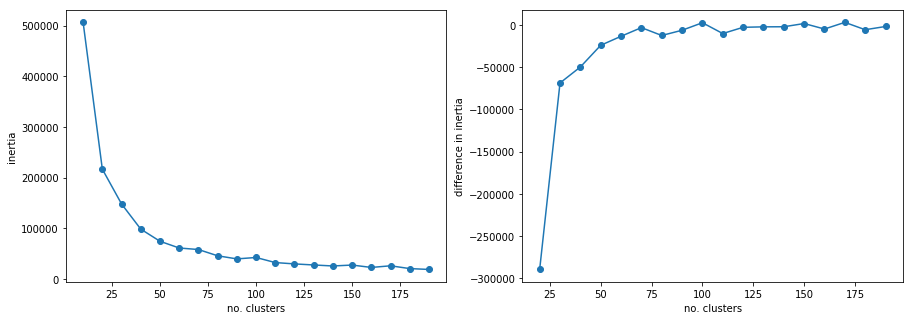

In [7]:
n_clusters = np.arange(10,200,10)
inertias = []
for n in n_clusters:
    print(n)
    clusterer = MiniBatchKMeans(n_clusters=n)

    #clusterer.fit(lda_vectors[lda_vectors.max(axis=1)>0.2])
    clusterer.fit(X_umap[lda_vectors.max(axis=1)>0.2])

    inertias.append(clusterer.inertia_)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(n_clusters,inertias,'o-')
plt.xlabel('no. clusters')
plt.ylabel('inertia')

plt.subplot(1,2,2)
plt.plot(n_clusters,pd.Series(inertias).diff(),'o-')
plt.xlabel('no. clusters')
plt.ylabel('difference in inertia')

In [ ]:
import seaborn as sns

mean_topic_cluster = pd.DataFrame(lda_vectors, index=pmids).groupby(clusters).mean()

plt.figure(figsize=(12,8))
sns.heatmap(mean_topic_cluster>0.1)